In [1]:
import sys
import time
import common
import argparse
import datasets
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
import estimators as estimators_lib
import tensorflow as tf
import tensorflow_lattice as tfl

In [1]:
def Oracle(table, query):
    cols, idxs, ops, vals = query
    oracle_est = estimators_lib.Oracle(table)

    return oracle_est.Query(cols, ops, vals)


def cal_true_card(query, table):
    cols, idxs, ops, vals = query
    ops = np.array(ops)
    probs = Oracle(table, (cols, idxs, ops, vals))
    return probs


def GenerateQuery(table, min_num_filters, max_num_filters, rng, dataset):
    """Generate a random query."""
    num_filters = rng.randint(max_num_filters - 1, max_num_filters)
    cols, idxs, ops, vals = SampleTupleThenRandom(table, num_filters, rng, dataset)
    sel = cal_true_card((cols, idxs, ops, vals), table) / float(table.cardinality)
    return cols, idxs, ops, vals, sel


def SampleTupleThenRandom(table, num_filters, rng, dataset):
    vals = []
    new_table = table.data
    s = new_table.iloc[rng.randint(0, new_table.shape[0])]
    vals = s.values

    if dataset in ["dmv", "dmv-tiny", "order_line"]:
        vals[6] = vals[6].to_datetime64()
    elif dataset in ["orders1", "orders"]:
        vals[4] = vals[4].to_datetime64()
    elif dataset == "lineitem":
        vals[10] = vals[10].to_datetime64()
        vals[11] = vals[11].to_datetime64()
        vals[12] = vals[12].to_datetime64()

    idxs = rng.choice(len(table.columns), replace=False, size=num_filters)
    cols = np.take(table.columns, idxs)
    # If dom size >= 10, okay to place a range filter.
    # Otherwise, low domain size columns should be queried with equality.
    # ops = rng.choice(['<=', '>=', '='], size=num_filters)
    # ops = rng.choice(['<=', '>='], size=num_filters)
    ops = rng.choice(["<="], size=num_filters)
    # ops_all_eqs = ['='] * num_filters
    # sensible_to_do_range = [c.DistributionSize() >= 10 for c in cols]
    # ops = np.where(sensible_to_do_range, ops, ops_all_eqs)
    # if num_filters == len(table.columns):
    #     return table.columns,np.arange(len(table.columns)), ops, vals
    vals = vals[idxs]
    op_a = []
    val_a = []
    for i in range(len(vals)):
        val_a.append([vals[i]])
        op_a.append([ops[i]])
    return cols, idxs, pd.DataFrame(op_a).values, pd.DataFrame(val_a).values


def dictionary_column_interval(table_size, query_set):
    # Traverse all queries to apply the intervalization skill for each column
    n_column = table_size[1]
    column_interval = {}
    for i in range(n_column):
        column_interval[i] = set()  # use set([0, sys.maxsize]) to adapt '>' and '<'.
    for query in query_set:
        _, col_idxs, _, vals, _ = query
        for i in range(len(col_idxs)):
            column_interval[col_idxs[i]].add(vals[i][0])
    for k, v in column_interval.items():
        if not v:
            column_interval[k] = [0]  # use [0] to represent empty column interval
        else:
            column_interval[k] = sorted(list(v))
    return column_interval


def count_column_unique_interval(unique_intervals):
    # count unique query interval in each column
    return [len(v) for v in unique_intervals.values()]


def execute_query(dataNew, query_set):
    diff = []
    for query in tqdm(query_set):
        sentence = ""
        for i in range(len(query[0])):
            if i != 0:
                sentence += " and "
            sentence += f"col_{query[1][i]}"
            if query[2][i][0] == "=":
                sentence += "=="
            else:
                sentence += query[2][i][0]
            sentence += f"{query[3][i][0]}"
        sel = dataNew.query(sentence).shape[0] / dataNew.shape[0]
        sel2 = query[4]  # round(query[4] * n_row)
        if sel == 0:
            sel += 1 / dataNew.shape[0]
        if sel2 == 0:
            sel2 += 1 / n_row
        if sel < sel2:
            diff.append(sel2 / sel)
        else:
            diff.append(sel / sel2)
    return diff


def print_error(diff, args):
    print(
        f"\n\n Q-error of Lattice (query size={args.query_size}, condition={args.num_conditions}):\n"
    )
    print(f"min:    {np.min(diff)}")
    print(f"10:     {np.percentile(diff, 10)}")
    print(f"20:     {np.percentile(diff, 20)}")
    print(f"30:     {np.percentile(diff, 30)}")
    print(f"40:     {np.percentile(diff, 40)}")
    print(f"median: {np.median(diff)}")
    print(f"60:     {np.percentile(diff, 60)}")
    print(f"70:     {np.percentile(diff, 70)}")
    print(f"80:     {np.percentile(diff, 80)}")
    print(f"90:     {np.percentile(diff, 90)}")
    print(f"95:     {np.percentile(diff, 95)}")
    print(f"max:    {np.max(diff)}")
    print(f"mean:   {np.mean(diff)}")


def calc_time(tic, toc):
    total_time = toc - tic
    m, s = divmod(total_time, 60)
    h, m = divmod(m, 60)
    return f"{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}"


class LatticeCDF:
    def __init__(
        self,
        name,
        n_row,
        unique_intervals,
        pwl_keypoints=None,  # also can input table unique values
        lattice_size=2,
        l2=1e-6,
    ):

        self.l2 = l2
        self.model_path = "./models/Lattice/model/" + name
        self.weight_path = "./models/Lattice/weight/" + name
        self.n_row = n_row
        self.dim = len(unique_intervals.keys())
        self.lattice_size = lattice_size
        self.unique_intervals = unique_intervals
        self.pwl_calibration_input_keypoints = (
            unique_intervals if pwl_keypoints is None else pwl_keypoints
        )

        self.model_inputs = []
        for i in range(self.dim):
            self.model_inputs.append(tf.keras.layers.Input(shape=[1], name="col_%s" % i))
            # self.model_inputs.append(
            #     tf.keras.layers.Input(shape=[1], name='col%s_l' % i))
            # self.model_inputs.append(
            #     tf.keras.layers.Input(shape=[1], name='col%s_u' % i))

        self.calibrators = []
        for i in range(self.dim):
            # self.calibrators.append(
            #     tfl.layers.PWLCalibration(
            #         input_keypoints=np.linspace(
            #             feat_mins[i],
            #             feat_maxs[i],
            #             num=pwl_calibration_num_keypoints),
            #         dtype=tf.float32,
            #         output_min=0.0,
            #         output_max=lattice_size - 1.0,
            #         monotonicity='decreasing',
            #     ))
            self.calibrators.append(
                tfl.layers.PWLCalibration(
                    input_keypoints=np.array(self.pwl_calibration_input_keypoints[i]),
                    # input_keypoints=np.linspace(
                    #     feat_mins[i],
                    #     feat_maxs[i],
                    #     num=pwl_calibration_num_keypoints),
                    dtype=tf.float32,
                    output_min=0.0,
                    output_max=1.0,
                    monotonicity="increasing",
                )
            )

        self.lattice = tfl.layers.Lattice(
            lattice_sizes=[lattice_size] * self.dim,  # (self.dim * 2),
            # lattice_sizes=[len(v) for v in self.unique_intervals.values()],
            interpolation="simplex",  # 可以尝试别的插值类型
            monotonicities=["increasing"] * self.dim,  # (self.dim * 2),
            output_min=0,  # 1 / self.n_row,
            output_max=1.0,
            name="lattice",
        )

        # self.output1 = tfl.layers.PWLCalibration(
        #     input_keypoints=np.linspace(0.0,
        #                                 np.log(n_row),
        #                                 num=pwl_calibration_num_keypoints),
        #     dtype=tf.float32,
        #     output_min=0.0,
        #     output_max=np.log(n_row),
        #     name='output1_calib',
        # )

        # self.output2 = tfl.layers.PWLCalibration(
        #     input_keypoints=np.linspace(0.0,
        #                                 n_row,
        #                                 num=pwl_calibration_num_keypoints),
        #     dtype=tf.float32,
        #     output_min=0.0,
        #     output_max=n_row,
        #     name='output2_calib',
        # )

        # self.lattice_inputs = []
        # for i in range(self.dim):  # (self.dim) * 2):
        #     self.lattice_inputs.append(self.calibrators[i](
        #         self.model_inputs[i]))
        # self.model_output = self.output2(
        #     tf.keras.backend.exp(
        #         self.output1(self.lattice(self.lattice_inputs))))

        self.lattice_inputs = []
        for i in range(self.dim):  # (self.dim) * 2):
            self.lattice_inputs.append(self.calibrators[i](self.model_inputs[i]))

        self.model_output = self.lattice(self.lattice_inputs)

        self.model = tf.keras.models.Model(
            inputs=self.model_inputs,
            outputs=self.calibrators[0](self.model_inputs[0]),  #######self.model_output,
        )
        self.model.save("%s.hdf5" % self.model_path)
        self.model.summary()

    def fit(
        self,
        X,
        y,
        lr=0.01,
        bs=16,
        epochs=3000,
        reduceLR_factor=0.5,
        reduceLR_patience=20,
        verbose=1,
        loss="MSE",
        opt="Adam",
    ):
        assert X.shape[0] == y.shape[0]
        # assert X.shape[1] == self.dim * 2

        X = X.astype(np.float32)
        y = y.astype(np.float32)

        # for i in range(self.dim):
        #     self.calibrators[i].input_keypoints = compute_quantiles(
        #         X[:, i].ravel(),
        #         num_keypoints=self.pwl_calibration_num_keypoints,
        #     )
        # self.calibrators[i * 2].input_keypoints = compute_quantiles(
        #     X[:, [i * 2, i * 2 + 1]].ravel(),
        #     num_keypoints=self.pwl_calibration_num_keypoints,
        # )
        # self.calibrators[i * 2 + 1].input_keypoints = compute_quantiles(
        #     X[:, [i * 2, i * 2 + 1]].ravel(),
        #     num_keypoints=self.pwl_calibration_num_keypoints,
        # )

        features = [X[:, i] for i in range(X.shape[1])]
        target = y

        Loss = {
            "MAE": tf.keras.losses.mean_absolute_error,
            "MSE": tf.keras.losses.mean_squared_error,
            "MAPE": tf.keras.losses.mean_absolute_percentage_error,
        }

        Opt = {
            "Adam": tf.keras.optimizers.Adam(),
            "Nadam": tf.keras.optimizers.Nadam(),
            "Adagrad": tf.keras.optimizers.Adagrad(),
            "Adadelta": tf.keras.optimizers.Adadelta(),
            "Adamax": tf.keras.optimizers.Adamax(),
            "RMSprop": tf.keras.optimizers.RMSprop(),
        }
        self.model.compile(loss=Loss[loss], optimizer=Opt[opt])
        # self.model.compile(loss=Loss[loss], optimizer=tf.keras.optimizers.Adamax(lr))

        earlyStopping = tf.keras.callbacks.EarlyStopping(
            monitor="loss", patience=500, verbose=verbose, mode="min"
        )
        mcp_save = tf.keras.callbacks.ModelCheckpoint(
            "%s.hdf5" % self.weight_path,
            save_best_only=True,
            monitor="loss",
            mode="min",
            save_weights_only=True,
        )
        reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="loss",
            factor=reduceLR_factor,
            patience=reduceLR_patience,
            verbose=verbose,
            epsilon=1e-10,
            mode="min",
        )

        self.model.fit(
            features,
            target,
            epochs=epochs,
            batch_size=bs,
            verbose=1,
            callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
        )
        self.model.load_weights("%s.hdf5" % self.weight_path)

    def load(self):
        self.model = tf.keras.models.load_model("%s.hdf5" % self.model_path)
        self.model.load_weights("%s.hdf5" % self.weight_path)

    def inference(self, grid):
        # predict and generate table
        assert grid.shape[1] == self.dim
        # df_grid = pd.DataFrame(cart_2, columns=[f'col_{i}' for i in range(n_column)])
        pred = m.model.predict(np.hsplit(grid, self.dim))
        return pred

    def plotting(self, grid, pred):
        Xshape = len(np.unique(grid[:, 0]))
        Yshape = len(np.unique(grid[:, 1]))
        X = grid[:, 1].reshape(Xshape, Yshape)
        Y = grid[:, 0].reshape(Xshape, Yshape)
        Z = pred.reshape(Xshape, Yshape)

        fig0 = plt.figure(figsize=(20, 8))
        ax0 = fig0.add_subplot(111)
        ax0.plot(pred, "bo")
        plt.show()

        fig1 = plt.figure(figsize=(15, 8))
        ax1 = plt.axes(projection="3d")
        ax1.plot_surface(X, Y, Z, cmap="viridis")
        plt.show()

        fig2 = plt.figure(figsize=(10, 8))
        ax2 = fig2.add_subplot(111)
        cs = ax2.contourf(X, Y, Z, cmap="viridis")
        # Alternatively, you can manually set the levels
        # and the norm:
        # lev_exp = np.arange(np.floor(np.log10(z.min())-1),
        #                    np.ceil(np.log10(z.max())+1))
        # levs = np.power(10, lev_exp)
        # cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())    # 这个是啥
        cbar = fig2.colorbar(cs)  # 让colorbar细粒度更高一点
        plt.show()

        # query 对网格的覆盖率 散点图
        fig3 = plt.figure(figsize=(10, 10))
        xtick = unique_intervals[0]
        ytick = unique_intervals[1]
        plt.scatter(train_X[:, 0], train_X[:, 1], c="b")
        plt.vlines(xtick, min(ytick), max(ytick), colors="green")
        plt.hlines(ytick, min(xtick), max(xtick), colors="green")
        plt.show()

    def generate(self, grid):
        assert grid.shape[1] == self.dim
        pred = m.model.predict(np.hsplit(grid, self.dim))
        dataNew = pd.DataFrame(
            columns=[f"col_{i}" for i in range(n_column)],
            index=[i for i in range(np.prod(column_interval_number))],
        )

        # generate 一条再query一条，再generate下一条
        count = 0
        for i in trange(grid.shape[0]):
            sentence = ""
            for j in range(grid.shape[1]):
                if j != 0:
                    sentence += " and "
                sentence += f"col_{j}"  # 这里要改
                sentence += " <= "  # 这里也要改
                sentence += f"{grid[i][j]:f}"

            xi = pred[i][0] * n_row - dataNew.query(sentence).shape[0]

            if int(xi) > 0:
                floor = np.floor(xi)
                ceil = np.ceil(xi)
                if floor == ceil:
                    card = int(xi)
                else:
                    card = int(xi)
                #                     card = np.random.choice([floor, ceil],
                #                                             p=[xi - floor,
                #                                                ceil - xi]).astype("int")
                dataNew.iloc[count : count + card, :] = grid[i]
                count += card
        dataNew.dropna(axis=0, how="all", inplace=True)
        return dataNew

In [12]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--dataset", type=str, default="wine3", help="Dataset.")
    parser.add_argument("--loss", type=str, default="MSE", help="Loss.")
    parser.add_argument("--opt", type=str, default="Adam", help="Optimizer.")
    parser.add_argument("--query-size", type=int, default=100, help="query size")
    parser.add_argument("--num-conditions", type=int, default=1, help="num of conditions")
    parser.add_argument("--lr", type=float, default=1e-2, help="learning rate")
    parser.add_argument("--bs", type=int, default=1000, help="Batch size.")
    parser.add_argument("--lattice", type=int, default=2, help="Lattice size.")
    parser.add_argument("--seed", type=int, default=4321, help="Random seed")
    parser.add_argument("--sample", type=int, default=0, help="reload trained mode")
    parser.add_argument("--epochs", type=int, default=1000, help="Number of epochs to train for.")
    # args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    bs = int(args.bs)
    lr = float(args.lr)
    epochs = int(args.epochs)
    lattice = int(args.lattice)
    sample = int(args.sample)

    if args.dataset == "dmv-tiny":
        table = datasets.LoadDmv("dmv-tiny.csv")
    elif args.dataset == "dmv":
        table = datasets.LoadDmv()
    else:
        type_casts = {}
        if args.dataset in ["orders1"]:
            type_casts = {4: np.datetime64, 5: np.float}
        elif args.dataset in ["orders"]:
            type_casts = {4: np.datetime64}
        elif args.dataset == "lineitem":
            type_casts = {10: np.datetime64, 11: np.datetime64, 12: np.datetime64}
        elif args.dataset == "order_line":
            type_casts = {6: np.datetime64}

        table = datasets.LoadDataset(args.dataset + ".csv", args.dataset, type_casts=type_casts)
    table_train = table
    train_data = common.TableDataset(table_train)
    query_set = None

    print("Begin Generating Queries ...")
    time0 = time.time()
    rng = np.random.RandomState(args.seed)
    query_set = [
        GenerateQuery(table, 2, args.num_conditions + 1, rng, args.dataset)
        for i in trange(args.query_size)
    ]
    print("Complete Generating Queries.")

    # Lattice
    print("\n\nBuilding Lattice...")
    time1 = time.time()
    table_size = table.data.shape
    n_row = table_size[0]
    n_column = table_size[1]
    unique_intervals = dictionary_column_interval(table_size, query_set)
    column_interval_number = count_column_unique_interval(unique_intervals)
    train_X = []
    train_Y = []
    for query in query_set:
        x = [
            unique_intervals[i][-1] + 1 for i in range(n_column)
        ]  # 这里使用每个col_unique_interval的最后一个元素即可
        _, col_idxs, _, vals, sel = query
        for i in range(len(col_idxs)):
            x[col_idxs[i]] = vals[i][0]
        train_X.append(x)
        train_Y.append(sel)
    train_X = np.array(train_X).astype(np.float32)
    train_Y = np.array(train_Y).astype(np.float32).reshape(-1, 1)
    train = np.concatenate((train_X, train_Y), axis=1)
    train = np.unique(train, axis=0)
    train_X, train_Y = np.hsplit(train, [-1])
    name = f"{args.dataset}_{args.query_size}query_{args.num_conditions}column_{args.epochs}epoch"
    m = LatticeCDF(name, n_row, unique_intervals, pwl_keypoints=None)

    print("\n\nLattice is already built, begin training...\n")
    time2 = time.time()
    m.fit(train_X, train_Y, lr=lr, bs=bs, epochs=epochs, loss=args.loss, opt=args.opt)

    print("\nFinish training, begin generate table...")
    time3 = time.time()
    values = [v for v in unique_intervals.values()]
    mesh = np.meshgrid(*values)  # 所有unique interval 的笛卡尔积网格
    grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)
    dataNew = m.generate(grid)

    print("\nFinish generate table, begin calculate Q-error on new table...")
    time4 = time.time()
    diff = execute_query(dataNew, query_set)
    print_error(diff, args)

    print(f"\noriginal table shape: {table_size}")
    print(f"  Our table shape   : {dataNew.shape}")
    time5 = time.time()

    print("\nTime passed:")
    print(" Generate Query  :  ", calc_time(time0, time1))
    print(" Build  Lattice  :  ", calc_time(time1, time2))
    print("   Training      :  ", calc_time(time2, time3))
    print("Generate  Table  :  ", calc_time(time3, time4))
    print("Calculate Q-error:  ", calc_time(time4, time5))

100%|██████████| 100/100 [00:00<00:00, 1031.82it/s]

load dataset wine3.csv done
(6497, 3)
(6497, 3)
0
1
2
0 106
1 187
2 89
[31 36 36]
(6497, 3)
Begin Generating Queries ...
Complete Generating Queries.


Building Lattice...
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
col_0 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
col_1 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
col_2 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
pwl_calibration_6 (

67/67 [==============================] - 0s 4ms/sample - loss: 0.2029
Epoch 2/1000
67/67 [==============================] - 0s 114us/sample - loss: 0.1892
Epoch 3/1000
67/67 [==============================] - 0s 86us/sample - loss: 0.1763
Epoch 4/1000
67/67 [==============================] - 0s 81us/sample - loss: 0.1642
Epoch 5/1000
67/67 [==============================] - 0s 80us/sample - loss: 0.1528
Epoch 6/1000
67/67 [==============================] - 0s 87us/sample - loss: 0.1423
Epoch 7/1000
67/67 [==============================] - 0s 83us/sample - loss: 0.1326
Epoch 8/1000
67/67 [==============================] - 0s 88us/sample - loss: 0.1236
Epoch 9/1000
67/67 [==============================] - 0s 94us/sample - loss: 0.1155
Epoch 10/1000
67/67 [==============================] - 0s 95us/sample - loss: 0.1081
Epoch 11/1000
67/67 [==============================] - 0s 80us/sample - loss: 0.1016
Epoch 12/1000
67/67 [==============================] - 0s 86us/sample - loss: 0.0957
Ep

Epoch 98/1000
67/67 [==============================] - 0s 88us/sample - loss: 0.0620
Epoch 99/1000
67/67 [==============================] - 0s 90us/sample - loss: 0.0619
Epoch 100/1000
67/67 [==============================] - 0s 86us/sample - loss: 0.0618
Epoch 101/1000
67/67 [==============================] - 0s 99us/sample - loss: 0.0617
Epoch 102/1000
67/67 [==============================] - 0s 86us/sample - loss: 0.0616
Epoch 103/1000
67/67 [==============================] - 0s 94us/sample - loss: 0.0615
Epoch 104/1000
67/67 [==============================] - 0s 85us/sample - loss: 0.0615
Epoch 105/1000
67/67 [==============================] - 0s 91us/sample - loss: 0.0614
Epoch 106/1000
67/67 [==============================] - 0s 91us/sample - loss: 0.0613
Epoch 107/1000
67/67 [==============================] - 0s 88us/sample - loss: 0.0613
Epoch 108/1000
67/67 [==============================] - 0s 94us/sample - loss: 0.0612
Epoch 109/1000
67/67 [==============================] - 

Epoch 194/1000
67/67 [==============================] - 0s 88us/sample - loss: 0.0593
Epoch 195/1000
67/67 [==============================] - 0s 91us/sample - loss: 0.0593
Epoch 196/1000
67/67 [==============================] - 0s 89us/sample - loss: 0.0593
Epoch 197/1000
67/67 [==============================] - 0s 95us/sample - loss: 0.0593
Epoch 198/1000
67/67 [==============================] - 0s 86us/sample - loss: 0.0593
Epoch 199/1000
67/67 [==============================] - 0s 95us/sample - loss: 0.0593
Epoch 200/1000
67/67 [==============================] - 0s 90us/sample - loss: 0.0593
Epoch 201/1000
67/67 [==============================] - 0s 85us/sample - loss: 0.0593
Epoch 202/1000
67/67 [==============================] - 0s 95us/sample - loss: 0.0593
Epoch 203/1000
67/67 [==============================] - 0s 88us/sample - loss: 0.0593
Epoch 204/1000
67/67 [==============================] - 0s 87us/sample - loss: 0.0593
Epoch 205/1000
67/67 [==============================] 

Epoch 290/1000
67/67 [==============================] - 0s 97us/sample - loss: 0.0590
Epoch 291/1000
67/67 [==============================] - 0s 91us/sample - loss: 0.0590
Epoch 292/1000
67/67 [==============================] - 0s 91us/sample - loss: 0.0590
Epoch 293/1000
67/67 [==============================] - 0s 99us/sample - loss: 0.0590
Epoch 294/1000
67/67 [==============================] - 0s 88us/sample - loss: 0.0590
Epoch 295/1000
67/67 [==============================] - 0s 95us/sample - loss: 0.0590
Epoch 296/1000
67/67 [==============================] - 0s 86us/sample - loss: 0.0590
Epoch 297/1000
67/67 [==============================] - 0s 91us/sample - loss: 0.0590
Epoch 298/1000
67/67 [==============================] - 0s 89us/sample - loss: 0.0590
Epoch 299/1000
67/67 [==============================] - 0s 85us/sample - loss: 0.0590
Epoch 300/1000
67/67 [==============================] - 0s 98us/sample - loss: 0.0590
Epoch 301/1000
67/67 [==============================] 

67/67 [==============================] - 0s 100us/sample - loss: 0.0589
Epoch 386/1000
67/67 [==============================] - 0s 102us/sample - loss: 0.0589
Epoch 387/1000
67/67 [==============================] - 0s 105us/sample - loss: 0.0589
Epoch 388/1000
67/67 [==============================] - 0s 113us/sample - loss: 0.0589
Epoch 389/1000
67/67 [==============================] - 0s 108us/sample - loss: 0.0589
Epoch 390/1000
67/67 [==============================] - 0s 93us/sample - loss: 0.0589
Epoch 391/1000
67/67 [==============================] - 0s 118us/sample - loss: 0.0589
Epoch 392/1000
67/67 [==============================] - 0s 104us/sample - loss: 0.0589
Epoch 393/1000
67/67 [==============================] - 0s 104us/sample - loss: 0.0589
Epoch 394/1000
67/67 [==============================] - 0s 84us/sample - loss: 0.0589
Epoch 395/1000
67/67 [==============================] - 0s 113us/sample - loss: 0.0589
Epoch 396/1000
67/67 [==============================] - 0s 9

Epoch 481/1000
67/67 [==============================] - 0s 79us/sample - loss: 0.0589
Epoch 482/1000
67/67 [==============================] - 0s 87us/sample - loss: 0.0589
Epoch 483/1000
67/67 [==============================] - 0s 84us/sample - loss: 0.0589
Epoch 484/1000
67/67 [==============================] - 0s 87us/sample - loss: 0.0589
Epoch 485/1000
67/67 [==============================] - 0s 93us/sample - loss: 0.0589
Epoch 486/1000
67/67 [==============================] - 0s 87us/sample - loss: 0.0589
Epoch 487/1000
67/67 [==============================] - 0s 101us/sample - loss: 0.0589
Epoch 488/1000
67/67 [==============================] - 0s 77us/sample - loss: 0.0589
Epoch 489/1000
67/67 [==============================] - 0s 97us/sample - loss: 0.0589
Epoch 490/1000
67/67 [==============================] - 0s 91us/sample - loss: 0.0589
Epoch 491/1000
67/67 [==============================] - 0s 87us/sample - loss: 0.0589
Epoch 492/1000
67/67 [==============================]

Epoch 577/1000
67/67 [==============================] - 0s 88us/sample - loss: 0.0588
Epoch 578/1000
67/67 [==============================] - 0s 96us/sample - loss: 0.0588
Epoch 579/1000
67/67 [==============================] - 0s 89us/sample - loss: 0.0588
Epoch 580/1000
67/67 [==============================] - 0s 92us/sample - loss: 0.0588
Epoch 581/1000
67/67 [==============================] - 0s 88us/sample - loss: 0.0588
Epoch 582/1000
67/67 [==============================] - 0s 93us/sample - loss: 0.0588
Epoch 583/1000
67/67 [==============================] - 0s 92us/sample - loss: 0.0588
Epoch 584/1000
67/67 [==============================] - 0s 91us/sample - loss: 0.0588
Epoch 585/1000
67/67 [==============================] - 0s 90us/sample - loss: 0.0588
Epoch 586/1000
67/67 [==============================] - 0s 86us/sample - loss: 0.0588
Epoch 587/1000
67/67 [==============================] - 0s 97us/sample - loss: 0.0588
Epoch 588/1000
67/67 [==============================] 

Epoch 673/1000
67/67 [==============================] - 0s 84us/sample - loss: 0.0588
Epoch 674/1000
67/67 [==============================] - 0s 91us/sample - loss: 0.0588
Epoch 675/1000
67/67 [==============================] - 0s 90us/sample - loss: 0.0588
Epoch 676/1000
67/67 [==============================] - 0s 85us/sample - loss: 0.0588
Epoch 677/1000
67/67 [==============================] - 0s 94us/sample - loss: 0.0588
Epoch 678/1000
67/67 [==============================] - 0s 87us/sample - loss: 0.0588
Epoch 679/1000
67/67 [==============================] - 0s 87us/sample - loss: 0.0588
Epoch 680/1000
67/67 [==============================] - 0s 89us/sample - loss: 0.0588
Epoch 681/1000
67/67 [==============================] - 0s 86us/sample - loss: 0.0588
Epoch 682/1000
67/67 [==============================] - 0s 92us/sample - loss: 0.0588
Epoch 683/1000
67/67 [==============================] - 0s 91us/sample - loss: 0.0588
Epoch 684/1000
67/67 [==============================] 

67/67 [==============================] - 0s 84us/sample - loss: 0.0588
Epoch 769/1000
67/67 [==============================] - 0s 93us/sample - loss: 0.0588
Epoch 770/1000
67/67 [==============================] - 0s 85us/sample - loss: 0.0588
Epoch 771/1000
67/67 [==============================] - 0s 88us/sample - loss: 0.0588
Epoch 772/1000
67/67 [==============================] - 0s 96us/sample - loss: 0.0588
Epoch 773/1000
67/67 [==============================] - 0s 89us/sample - loss: 0.0588
Epoch 774/1000
67/67 [==============================] - 0s 96us/sample - loss: 0.0588
Epoch 775/1000
67/67 [==============================] - 0s 85us/sample - loss: 0.0588
Epoch 776/1000
67/67 [==============================] - 0s 90us/sample - loss: 0.0588
Epoch 777/1000
67/67 [==============================] - 0s 89us/sample - loss: 0.0588
Epoch 778/1000
67/67 [==============================] - 0s 84us/sample - loss: 0.0588
Epoch 779/1000
67/67 [==============================] - 0s 101us/samp

Epoch 864/1000
67/67 [==============================] - 0s 97us/sample - loss: 0.0588
Epoch 865/1000
67/67 [==============================] - 0s 83us/sample - loss: 0.0588
Epoch 866/1000
67/67 [==============================] - 0s 83us/sample - loss: 0.0588
Epoch 867/1000
67/67 [==============================] - 0s 95us/sample - loss: 0.0588
Epoch 868/1000
67/67 [==============================] - 0s 86us/sample - loss: 0.0588
Epoch 869/1000
67/67 [==============================] - 0s 87us/sample - loss: 0.0588
Epoch 870/1000
67/67 [==============================] - 0s 91us/sample - loss: 0.0588
Epoch 871/1000
67/67 [==============================] - 0s 87us/sample - loss: 0.0588
Epoch 872/1000
67/67 [==============================] - 0s 92us/sample - loss: 0.0588
Epoch 873/1000
67/67 [==============================] - 0s 98us/sample - loss: 0.0588
Epoch 874/1000
67/67 [==============================] - 0s 94us/sample - loss: 0.0588
Epoch 875/1000
67/67 [==============================] 

67/67 [==============================] - 0s 90us/sample - loss: 0.0588
Epoch 960/1000
67/67 [==============================] - 0s 92us/sample - loss: 0.0588
Epoch 961/1000
67/67 [==============================] - 0s 84us/sample - loss: 0.0588
Epoch 962/1000
67/67 [==============================] - 0s 92us/sample - loss: 0.0588
Epoch 963/1000
67/67 [==============================] - 0s 85us/sample - loss: 0.0588
Epoch 964/1000
67/67 [==============================] - 0s 83us/sample - loss: 0.0588
Epoch 965/1000
67/67 [==============================] - 0s 85us/sample - loss: 0.0588
Epoch 966/1000
67/67 [==============================] - 0s 80us/sample - loss: 0.0588
Epoch 967/1000
67/67 [==============================] - 0s 97us/sample - loss: 0.0588
Epoch 968/1000
67/67 [==============================] - 0s 86us/sample - loss: 0.0588
Epoch 969/1000
67/67 [==============================] - 0s 85us/sample - loss: 0.0588
Epoch 970/1000
67/67 [==============================] - 0s 98us/sampl

100%|██████████| 100/100 [00:00<00:00, 557.22it/s]


Finish generate table, begin calculate Q-error on new table...


 Q-error of Lattice (query size=100, condition=1):

min:    1.0365030306412903
10:     1.1301095842755262
20:     1.2308588796893927
30:     1.3339816933638444
40:     1.4299553405153524
median: 1.5560005946088795
60:     1.769817488422773
70:     2.0379548306148054
80:     2.601461620003742
90:     4.588276836158192
95:     8.571640240274972
max:    253.91334462059413
mean:   5.41608958751302

original table shape: (6497, 3)
  Our table shape   : (10925, 3)

Time passed:
 Generate Query  :   00:00:00
 Build  Lattice  :   00:00:00
   Training      :   00:00:07
Generate  Table  :   00:00:36
Calculate Q-error:   00:00:00


In [7]:
train_X = np.random.rand(10000, 6)

<IPython.core.display.Javascript object>


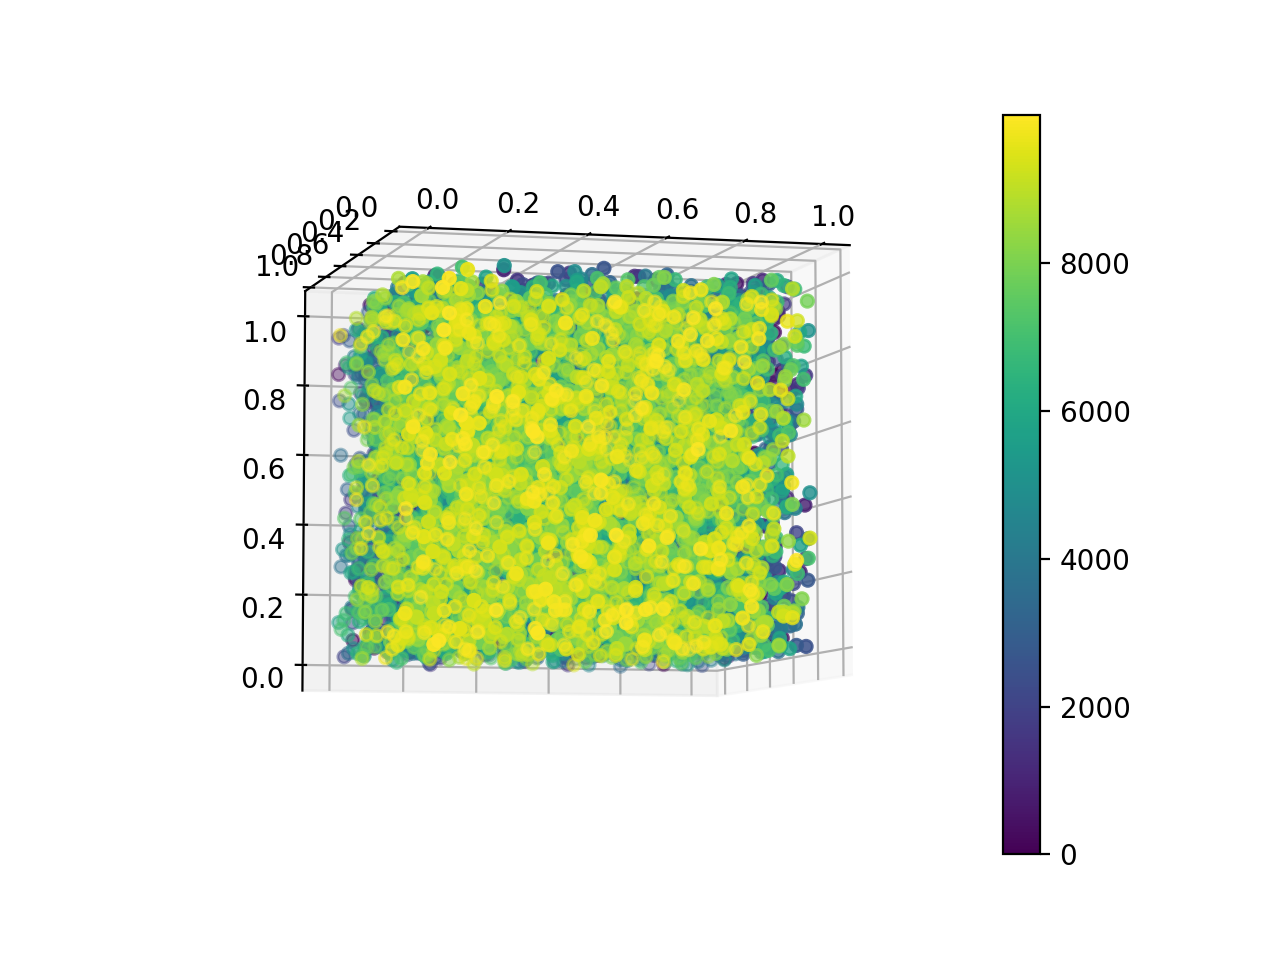

In [10]:
%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection='3d')
X = train_X[:, 1]
Y = train_X[:, 3]
Z = train_X[:, 5]
V = range(10000)
sc = ax.scatter(X, Y, Z, c=V)
plt.colorbar(sc)

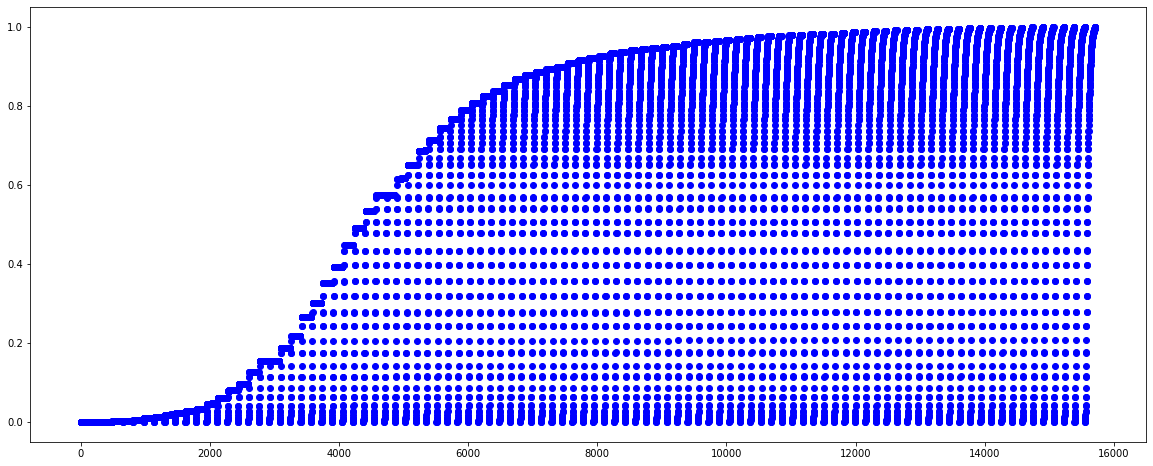

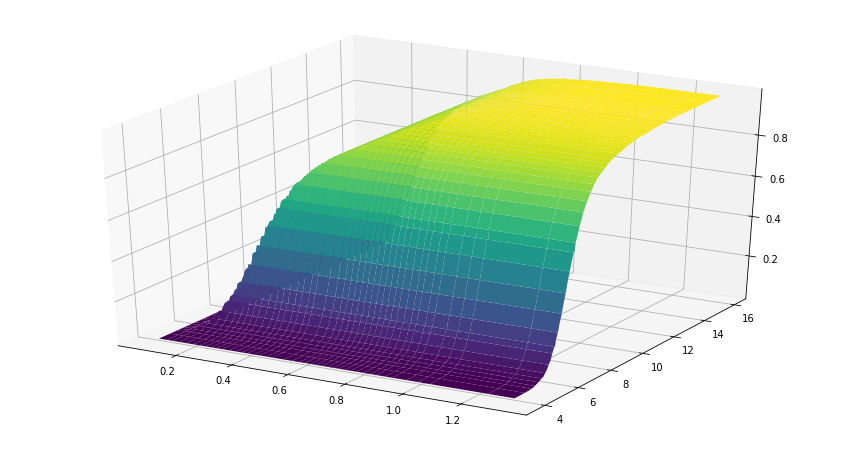

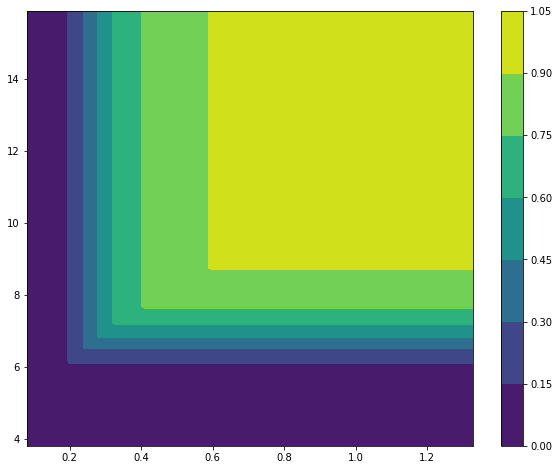

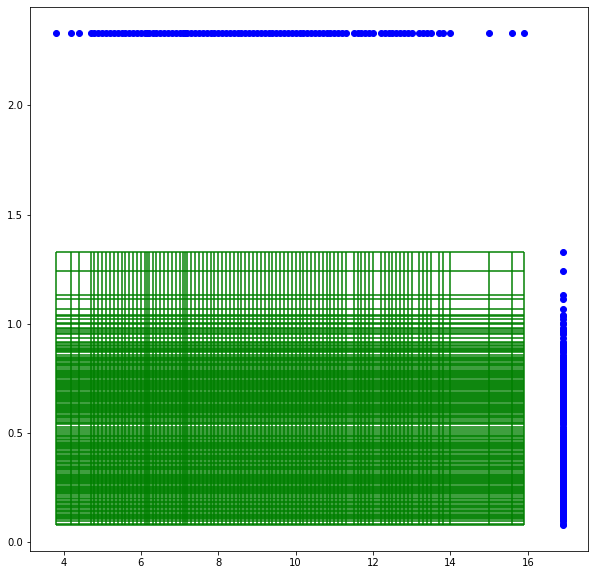

In [74]:
values = [v for v in unique_intervals.values()]
mesh = np.meshgrid(*values)  # 所有unique interval 的笛卡尔积网格
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)
pred = m.inference(grid)
m.plotting(grid, pred)

In [34]:
values = [v for v in unique_intervals.values()]
mesh = np.meshgrid(*values)  # 所有unique interval 的笛卡尔积网格
grid = np.array(mesh).T.reshape(-1, len(values)).astype(np.float32)
pred = m.model.predict(np.hsplit(grid, 2))

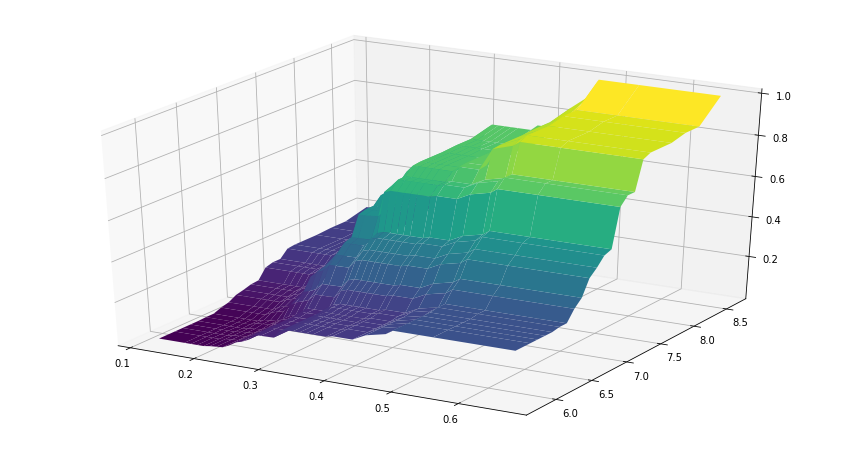

In [100]:
fig1 = plt.figure(figsize=(15, 8))
ax1 = plt.axes(projection="3d")

# xx = unique_intervals[1]
# yy = unique_intervals[0]
# X, Y = np.meshgrid(xx, yy)

X = grid[:, 1].reshape(column_interval_number[0], column_interval_number[1])  # 这样也可以
Y = grid[:, 0].reshape(column_interval_number[0], column_interval_number[1])
Z = pred.reshape(column_interval_number[0], column_interval_number[1])

ax1.plot_surface(X, Y, Z, cmap="viridis")
plt.show()

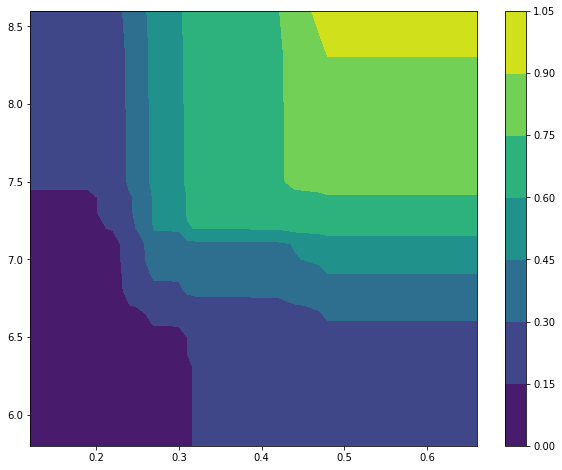

In [42]:
fig2 = plt.figure(figsize=(10, 8))
ax2 = fig2.add_subplot(111)
cs = ax2.contourf(X, Y, Z, cmap="viridis")

# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())    # 这个是啥

cbar = fig.colorbar(cs)  # 让colorbar细粒度更高一点
plt.show()

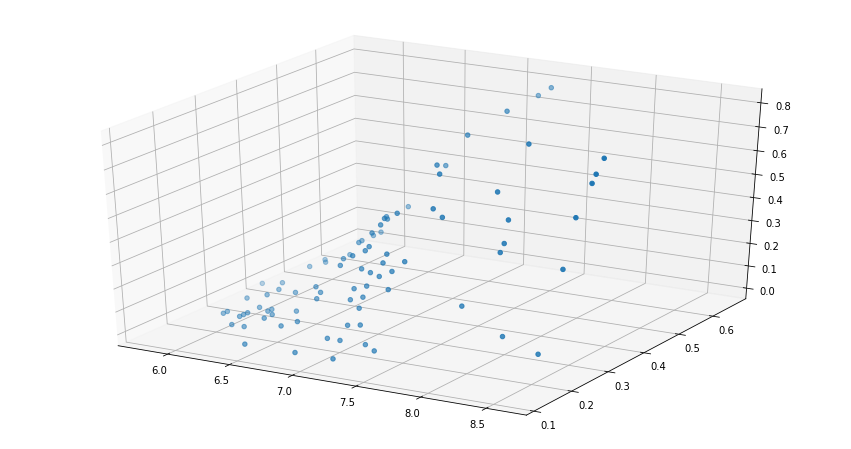

In [43]:
# query 对网格的覆盖率 散点图
fig3 = plt.figure(figsize=(15, 8))
ax3 = plt.axes(projection="3d")
z = train_Y
x = train_X[:, 0]
y = train_X[:, 1]
ax3.scatter3D(x, y, z, cmap="b")
plt.show()

In [53]:
from matplotlib import cm
%matplotlib notebook
stride = 0.01
X = np.arange(0, 1+stride, stride)
Y = np.arange(0, 1+stride, stride)
X, Y = np.meshgrid(X, Y)

In [ ]:
def M(x, y, theta=1):
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            a, b = x[i, j], y[i, j]
            if a <= b:
                z[i, j] = a * b ** (1 - theta)
            else:
                z[i, j] = a ** (1 - theta) * b
    return z

<IPython.core.display.Javascript object>


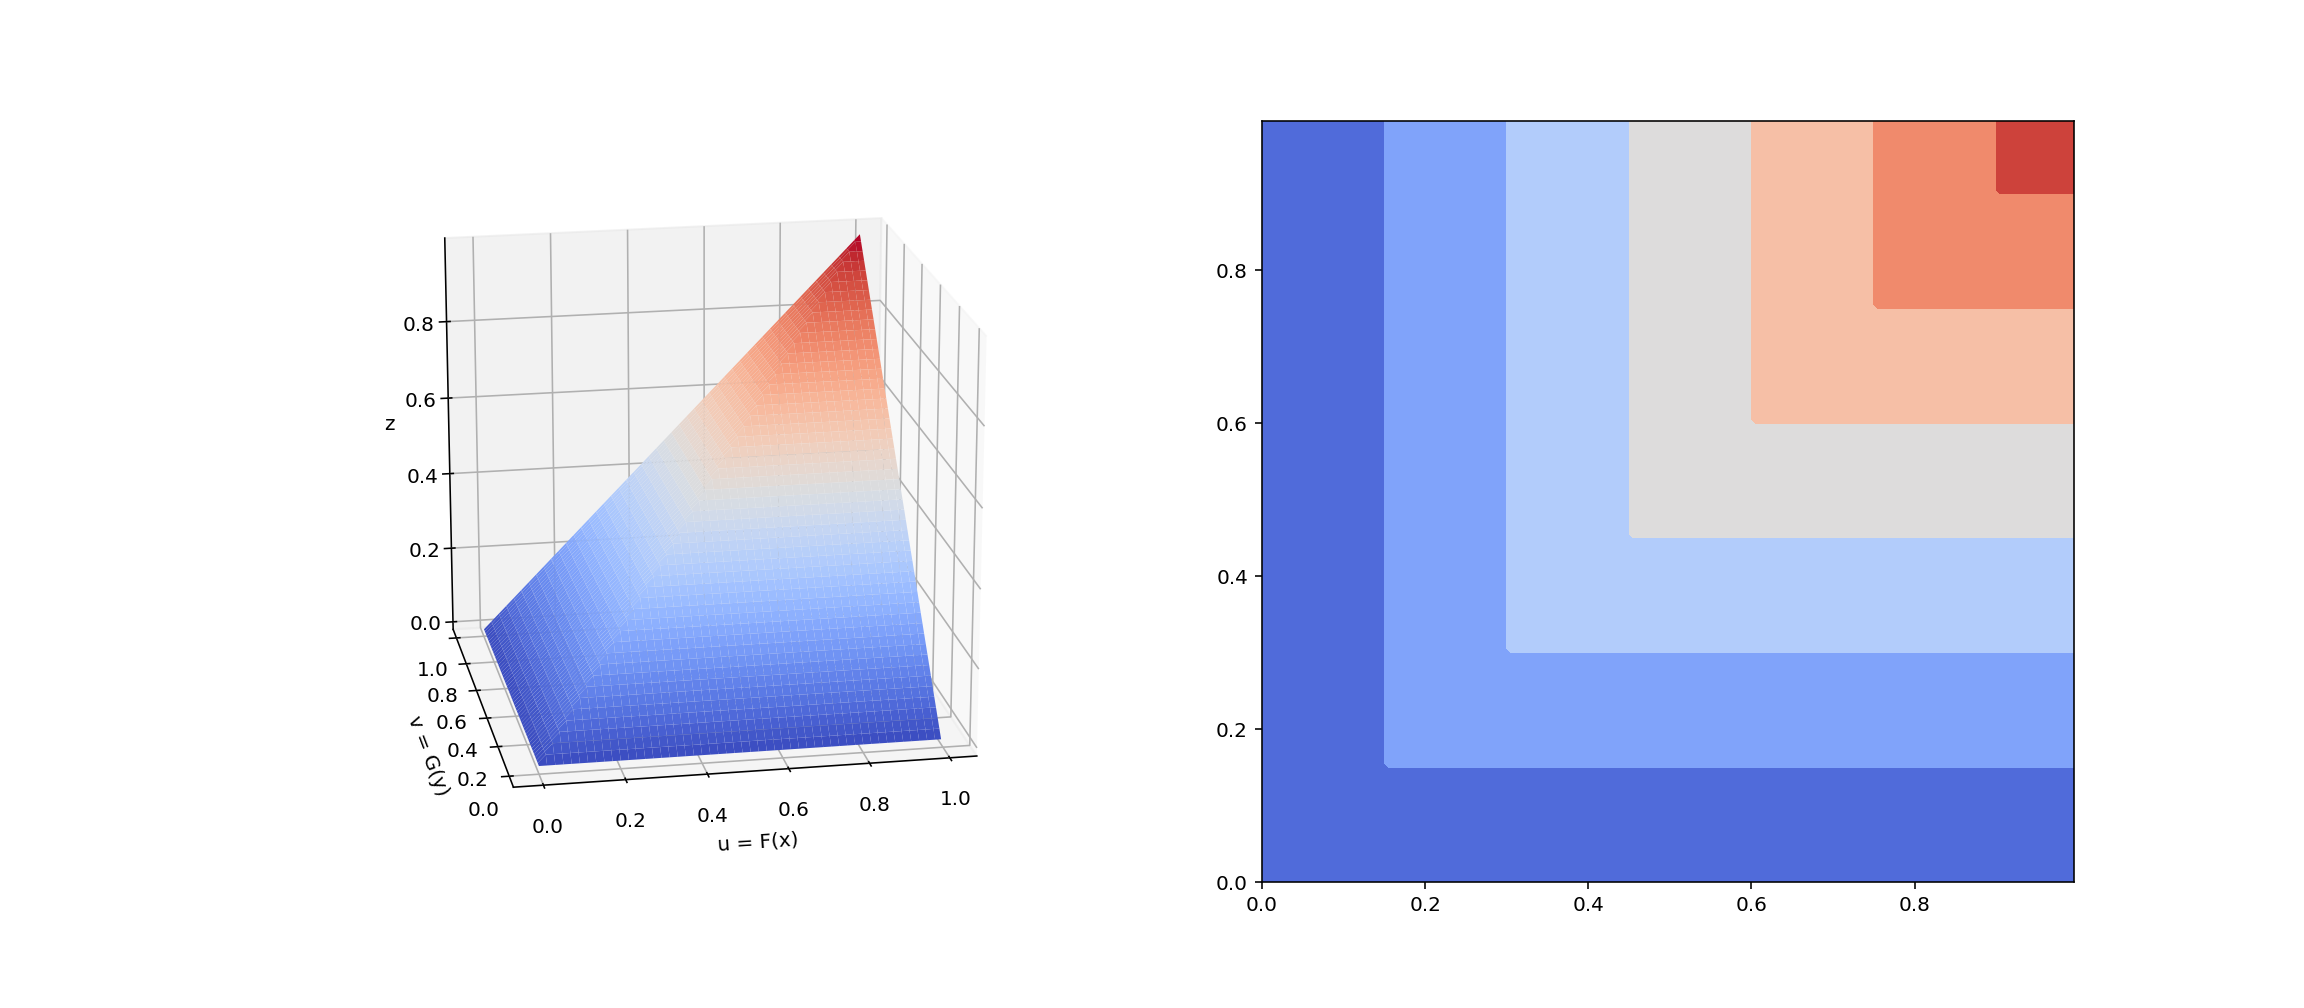

In [76]:
Z = M(X, Y)

fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(121, projection="3d")

ax1.plot_surface(X, Y, Z, cmap="coolwarm")
ax1.set_xlabel("u = F(x)")
ax1.set_ylabel("v = G(y)")
ax1.set_zlabel("z")

ax2 = fig.add_subplot(122)
ax2.contourf(X, Y, Z, cmap="coolwarm")

In [ ]:
def P(x, y, theta=0):
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            a, b = x[i, j], y[i, j]
            if a <= b:
                z[i, j] = a * b ** (1 - theta)
            else:
                z[i, j] = a ** (1 - theta) * b
    return z

<IPython.core.display.Javascript object>


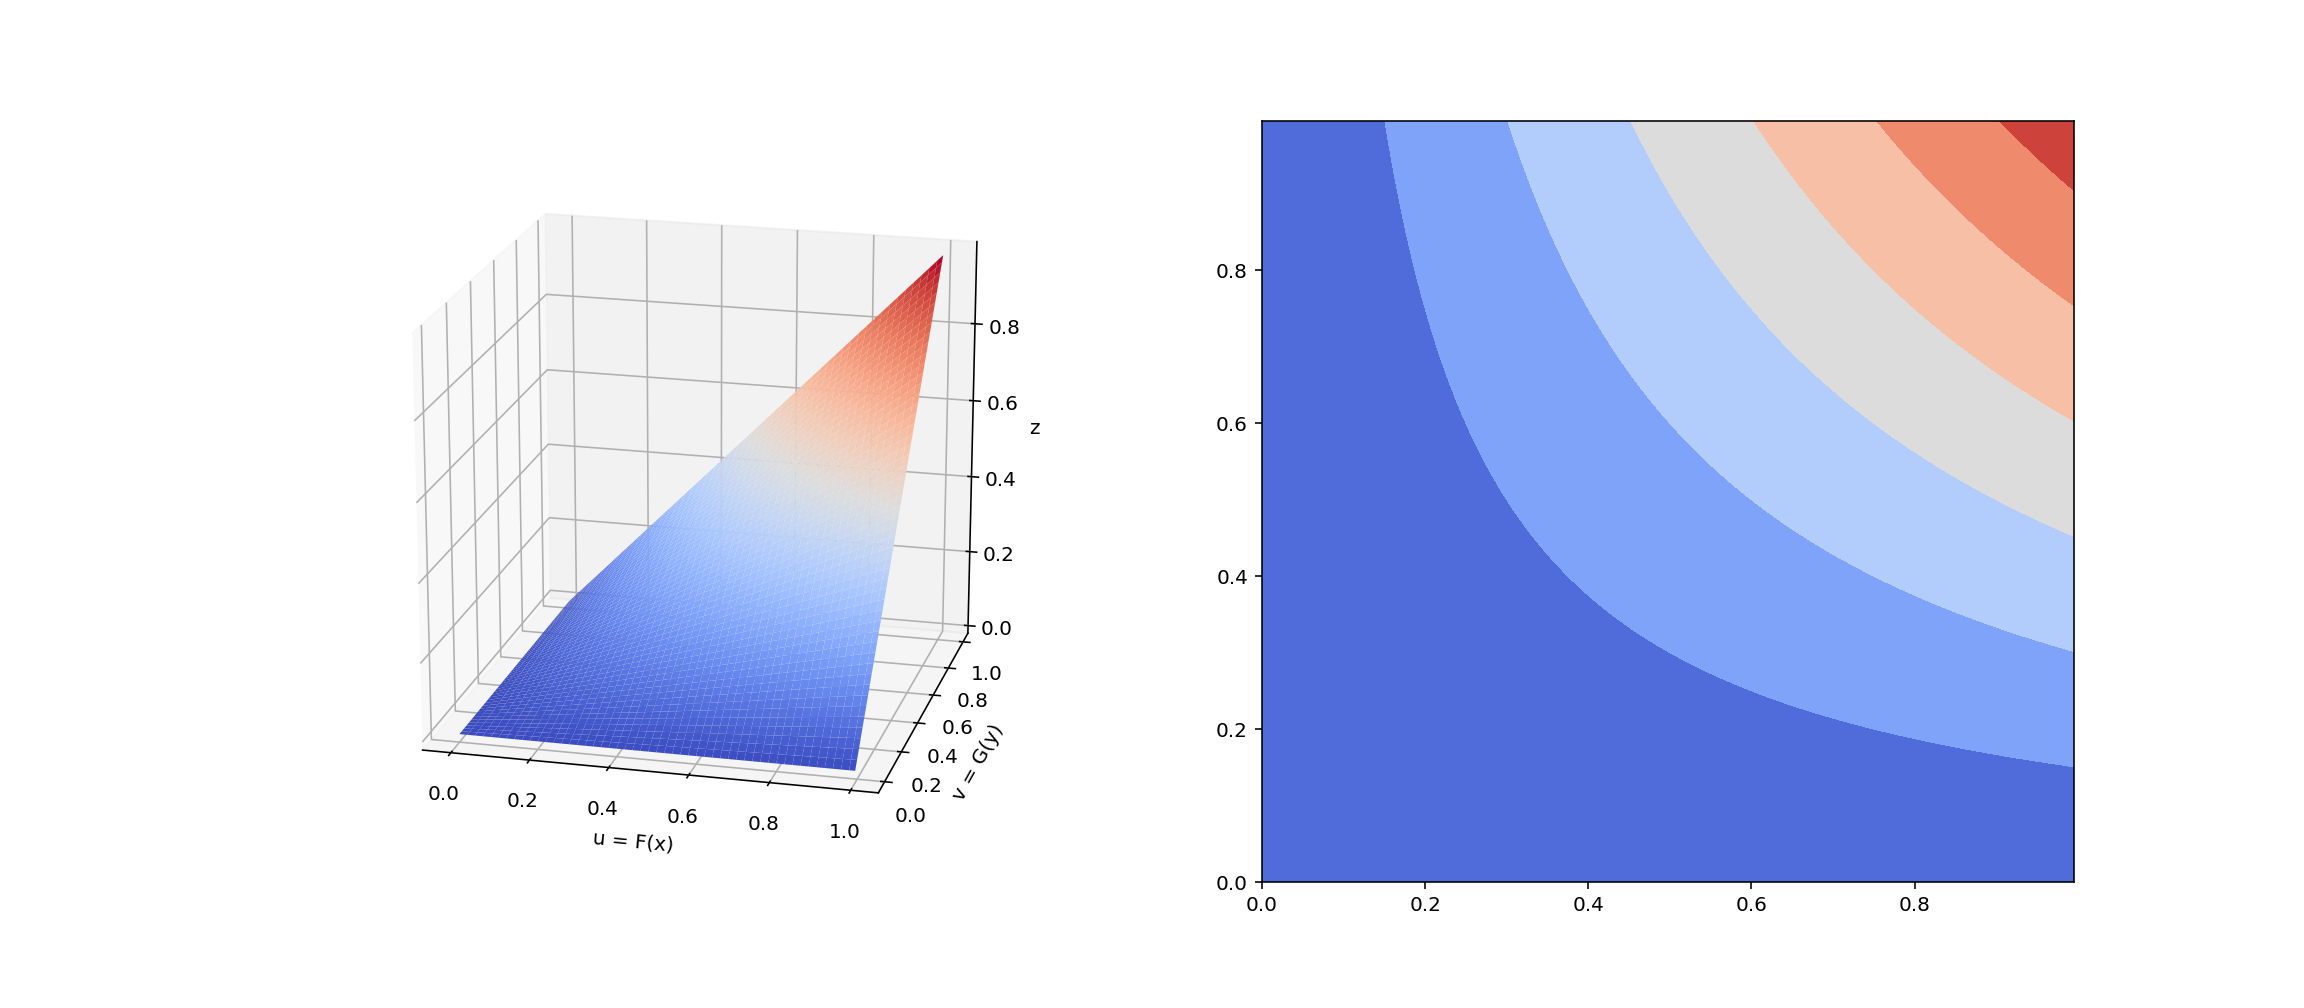

In [77]:
Z = P(X, Y)

fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(121, projection="3d")

ax1.plot_surface(X, Y, Z, cmap="coolwarm")
ax1.set_xlabel("u = F(x)")
ax1.set_ylabel("v = G(y)")
ax1.set_zlabel("z")

ax2 = fig.add_subplot(122)
ax2.contourf(X, Y, Z, cmap="coolwarm")

In [ ]:
def W(x, y):
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i, j] = max(x[i, j] + y[i, j] - 1, 0)
    return z

<IPython.core.display.Javascript object>


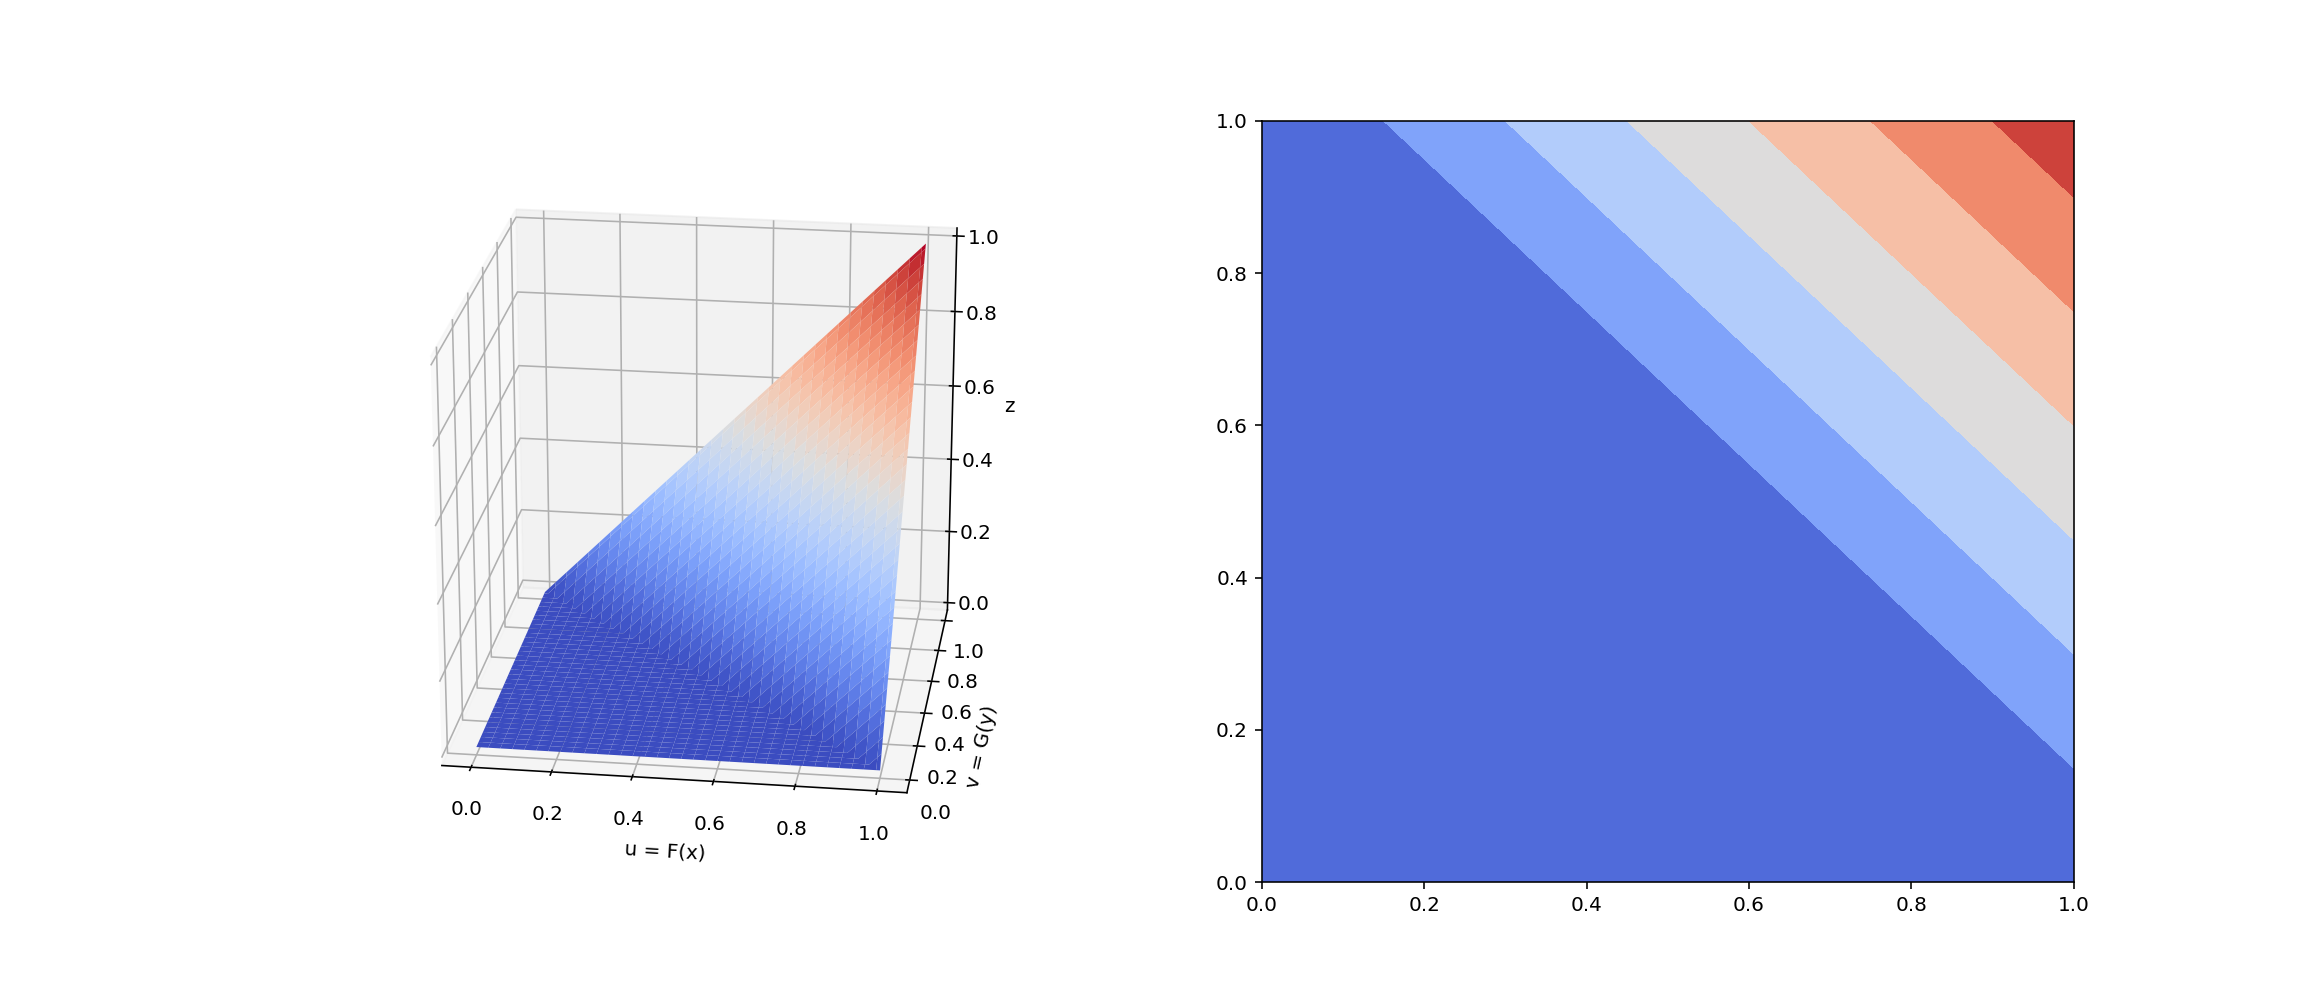

In [78]:
Z = W(X, Y)

fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(121, projection="3d")

ax1.plot_surface(X, Y, Z, cmap="coolwarm")
ax1.set_xlabel("u = F(x)")
ax1.set_ylabel("v = G(y)")
ax1.set_zlabel("z")

ax2 = fig.add_subplot(122)
ax2.contourf(X, Y, Z, cmap="coolwarm")

In [ ]:
def f(x, y):
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            a, b = x[i, j], y[i, j]
            if a + b >= 2 / 3 and a + b <= 4 / 3:
                z[i, j] = min(a, b, 1 / 3, a + b - 2 / 3)
            else:
                z[i, j] = max(a + b - 1, 0)
    return z

<IPython.core.display.Javascript object>


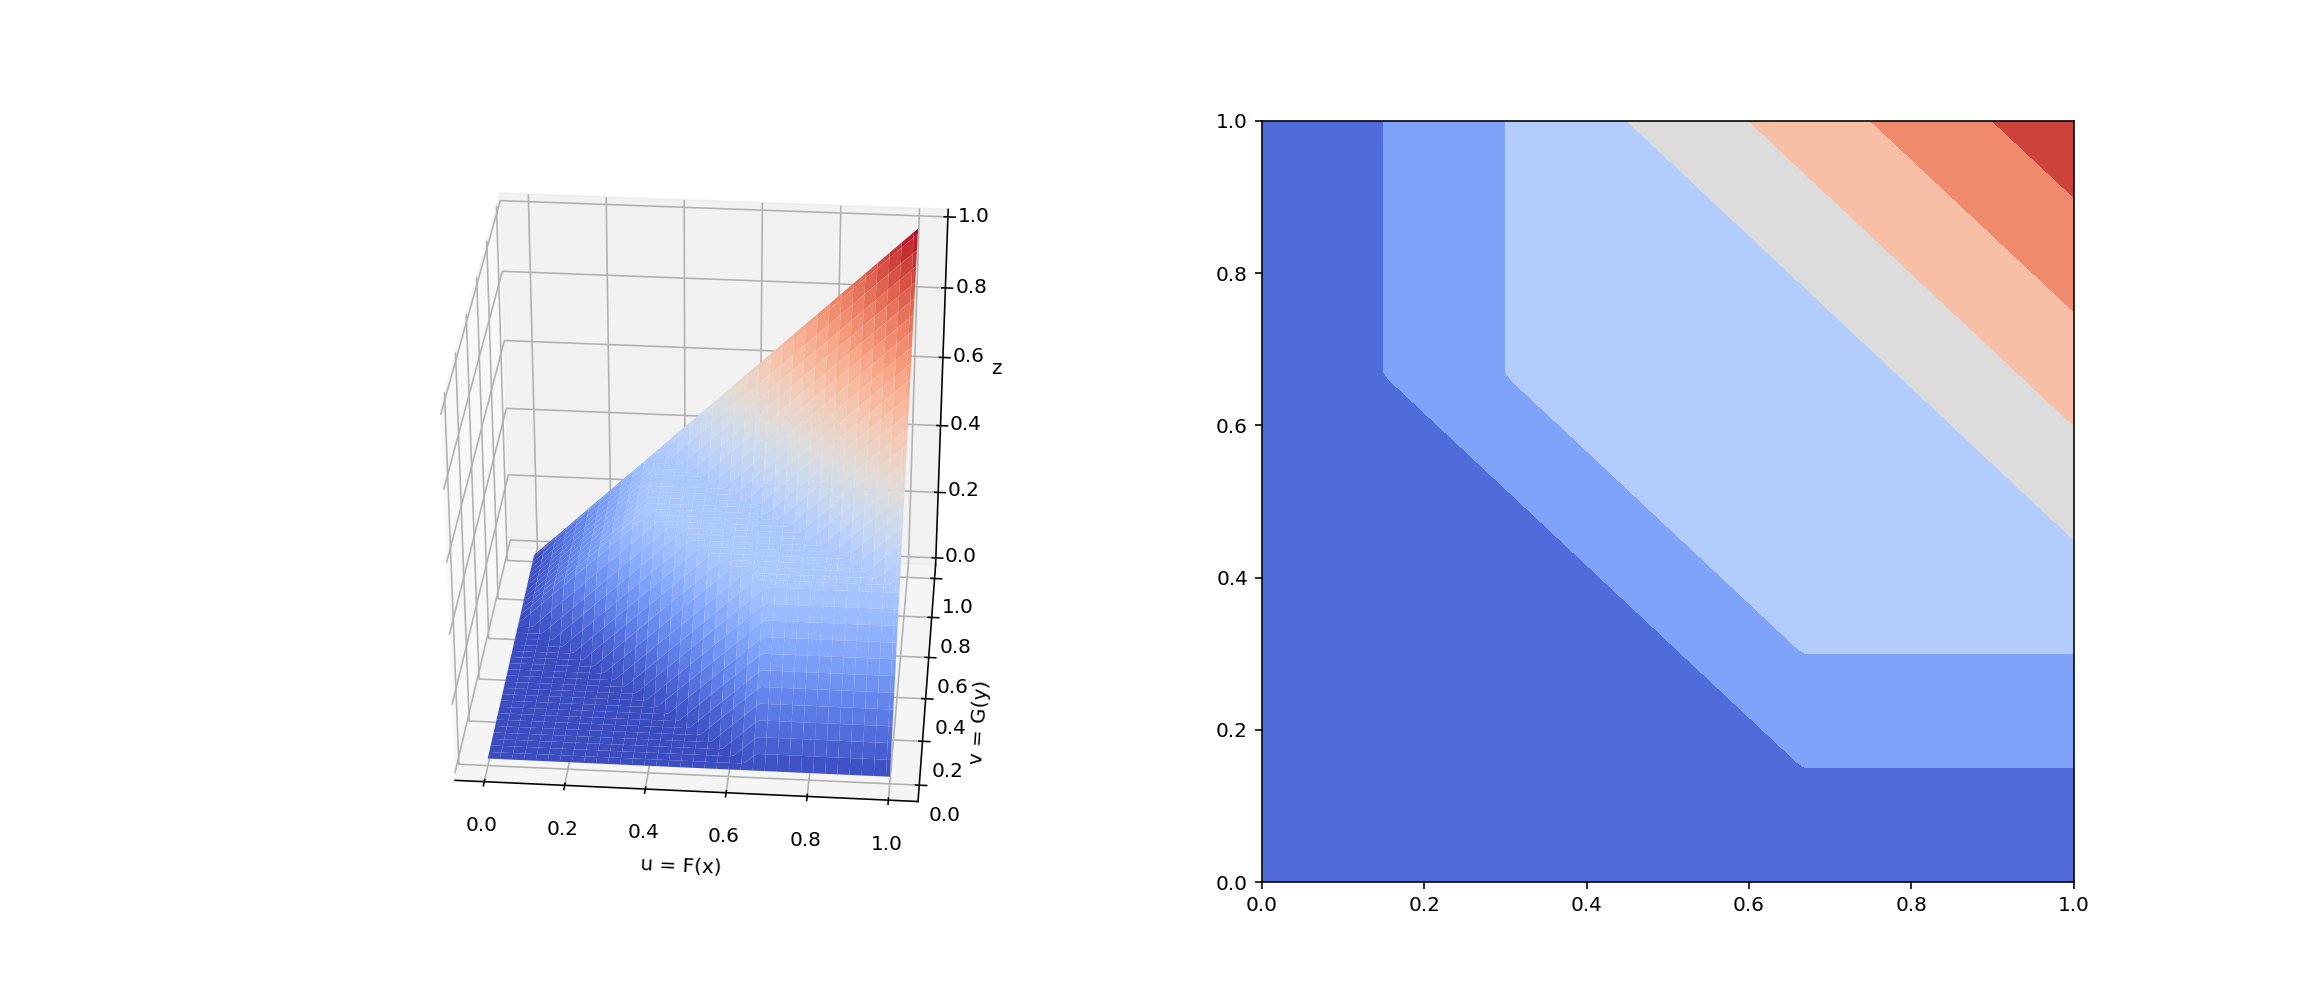

In [61]:
Z = f(X, Y)

fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(121, projection="3d")

ax1.plot_surface(X, Y, Z, cmap="coolwarm")
ax1.set_xlabel("u = F(x)")
ax1.set_ylabel("v = G(y)")
ax1.set_zlabel("z")

ax2 = fig.add_subplot(122)
ax2.contourf(X, Y, Z, cmap="coolwarm")

<IPython.core.display.Javascript object>


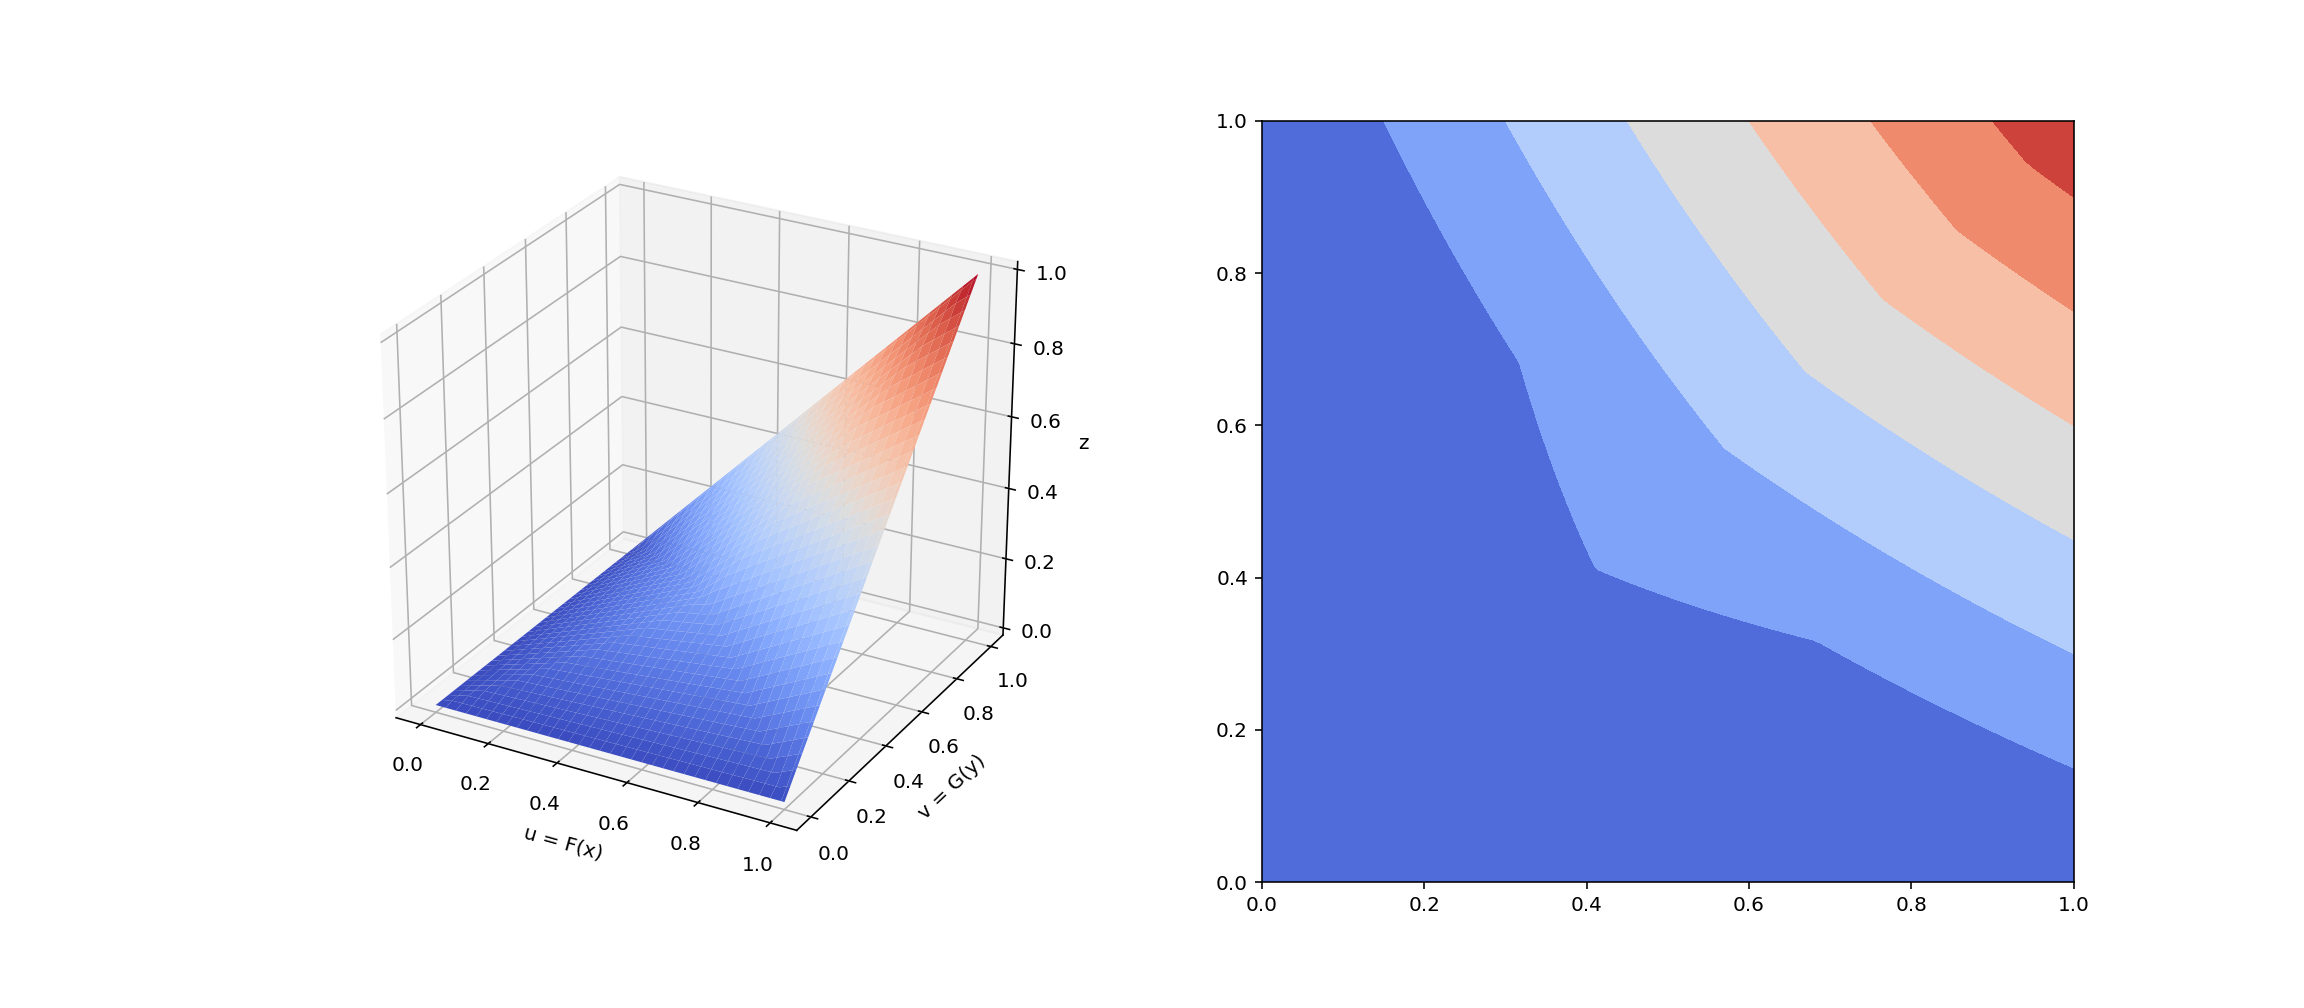

In [89]:
a, b = 0.2, 0.4

Z = a * M(X, Y) + (1 - a - b) * P(X, Y) + b * W(X, Y)

fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(121, projection="3d")

ax1.plot_surface(X, Y, Z, cmap="coolwarm")
ax1.set_xlabel("u = F(x)")
ax1.set_ylabel("v = G(y)")
ax1.set_zlabel("z")

ax2 = fig.add_subplot(122)
ax2.contourf(X, Y, Z, cmap="coolwarm")

In [91]:
def T(x, y, t):
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            a, b = x[i, j], y[i, j]
            if a >= t and b >= t:
                z[i, j] = max(a + b - 1, t)
            else:
                z[i, j] = min(a, b)
    return z

<IPython.core.display.Javascript object>


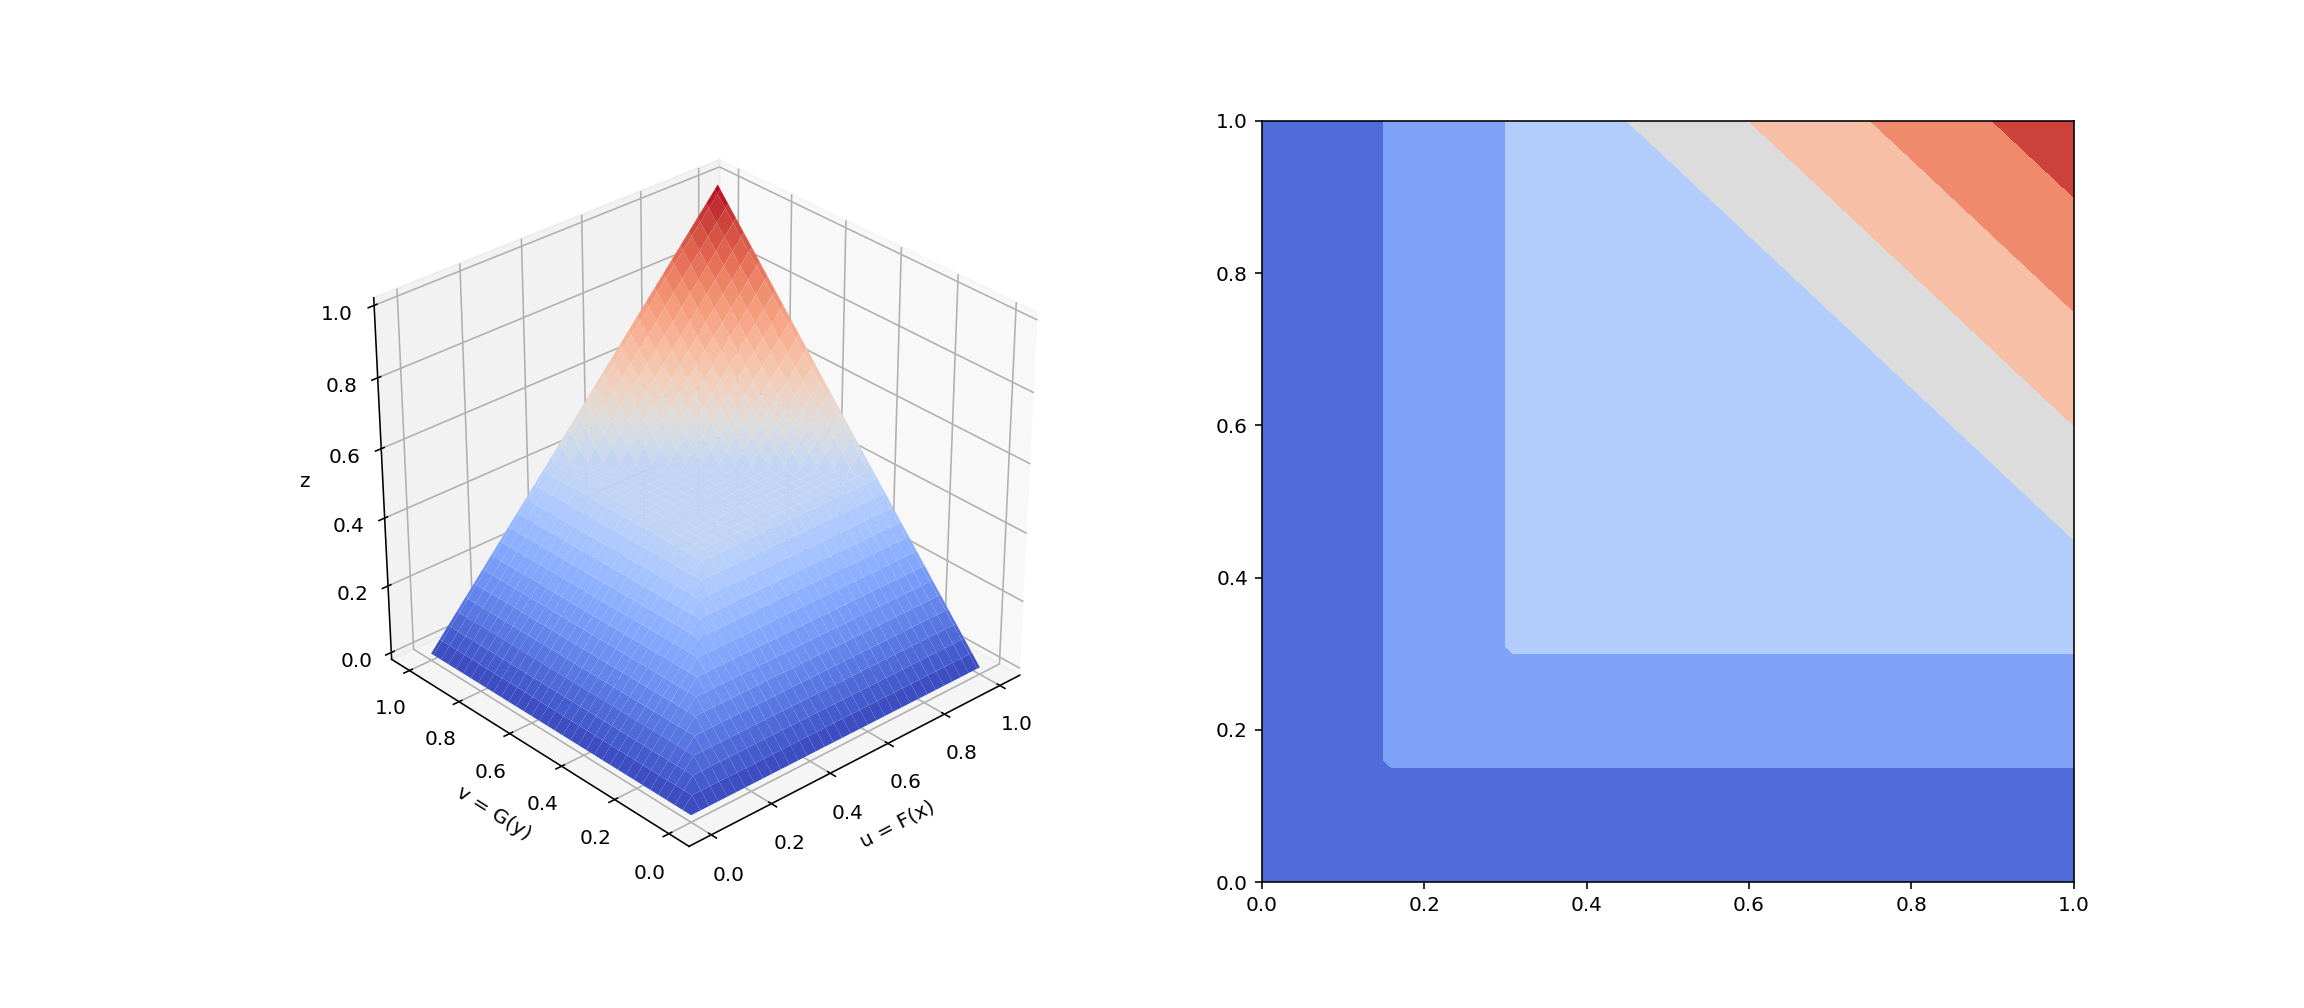

In [93]:
t = 0.4
Z = T(X, Y, t=t)

fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(121, projection="3d")

ax1.plot_surface(X, Y, Z, cmap="coolwarm")
ax1.set_xlabel("u = F(x)")
ax1.set_ylabel("v = G(y)")
ax1.set_zlabel("z")

ax2 = fig.add_subplot(122)
ax2.contourf(X, Y, Z, cmap="coolwarm")